## El objetivo de este ejercicio es calcular la función de política óptima epsilon greedy ("epsilon-ávida")
<img src="Epsilon_Greedy_MC.PNG">

In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
# vamos a utilizar el ambiente de BlackJack como ejemplo
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Crea una política epsilon-greedy basado en una q-función (función de valor estado-acción) y un epsilon dados.
    
    Argumentos:
        Q: un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
         
        epsilon: probabilidad de seleccionar una acción aleatoria (obliga a explorar), valor entre 0 y 1.
        
        nA: número de acciones en el entorno
    
    Retorna:
        Una función que dada una observación como argumento, retorna una política (un array de numpy de longitud nA)
        con probabilidades para cada acción. La política es tal que toma la mejor acción según Q con probabilidad (1-epsilon)
        y toma una acción al azar con probabilidad epsilon
        
    """
    def policy_fn(estado):
        # devolver un array de longitud nA con valores epsilon/nA para todas las acciones
        # excepto para la mejor acción según Q dada esta observación (estado), 
        # que debe tener probabilidad (1 - epsilon + epsilon/nA)
      
        p = np.ones(nA)*epsilon/nA
        mejor_accion = np.argmax(Q[estado])
        p[mejor_accion] += 1.0 - epsilon
        return p
        
        
    return policy_fn

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Control Monte Carlo utiliando políticas epsilon-greedy
    Encuentra la política epsilon-greedy óptima.
    
    Argumentos:
        env: ambiente de OpenAI gym.
        num_episodes: número de episodios a samplear.
        discount_factor: factor de descuento gama.
        epsilon: probabilidad de samplear una acción aleatoria. Valor entre 0 y 1.
    
    Retorna:
        Una tupla (Q, policy)
        Q es un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
        policy es una función que toma una observación/estado como argumento y retorna un array numpy 
        de longitud nA con las probabilidades de cada acción
        
    """
    
    # mantienen la suma y la cantidad de retornos para cada estado
    # para calcular un promedio. Podríamos utilizar un array para guardar todos los retornos
    # también, pero sería más infeciente en términos de espacio
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    # la función de valor estado-acción
    # es un diccionario cuyas llaves son estados
    # para cada estado el diccionario tiene un array de nA (cantidad de acciones) elementos
    # y cada elemento de este array dice Q(estado,accion), la función de valor estado-acción evaluada en el par
    # (estado, accion)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # la política que estamos siguiendo en este momento
    # la política que seguimos en el paso actual es la política epsilon-greedy
    # respecto a la estimación de Q que tenemos en este momento
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in range(num_episodes):
        # hacer print del número de episodio si es múltiplo de 1000 para observar el avance
        if i % 1000 == 0:
            print("\rEpisodio {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()

        episodio = []
        estado = env.reset()
        # generar un episodio de máximo 100 pasos (o parar cuando acabe el episodio)
        # un episodio es una lista de tuplas (estado, accion, recompensa)
        for t in range(100): # alternativamente: while True
            probabilidades = policy(estado)
            accion = np.random.choice(np.arange(len(probabilidades)), p=probabilidades)
            proximo_estado, recompensa, fin, _ = env.step(accion)
            episodio.append((estado, accion, recompensa))
            if fin:
                break
            estado = proximo_estado

        # con el episodio generado: 
        # obtener la lista de pares únicos (estado, acción) que ocurrieron en este episodio
        # TIP 1: podemos usar set() para obtener elementos únicos
        pares_en_episodio = [(tuple(x[0]), x[1]) for x in episodio]
        pares_unicos_en_episodio = set(pares_en_episodio)
        for estado, accion in pares_unicos_en_episodio: # para cada par (estado, accion)
            par_estado_accion = (estado, accion)
            # encontrar la primera ocurrencia del par (estado, accion en el episodio)
            primer_indice = pares_en_episodio.index(par_estado_accion)
            # sumar todas las recompensas descontadas a partir de ese momento:
            G = 0 
            for j in range(primer_indice, len(episodio)):
                tupla = episodio[j]
                G += tupla[2]*discount_factor**(j-primer_indice)
            # calcular el promedio del retorno dado todos los ejemplos que tenemos hasta ahora
            # para este par (estado, accion)
            # poemos usar el promedio o 
            returns_sum[par_estado_accion] += G
            returns_count[par_estado_accion] += 1.0

            ####### COMPLETAR la próxima línea con: (hay dos opciones) #############
            # 1 - el promedio usando returns_sum y returns_count para este par (estado, accion)
            # 2 - usando la fórmula incremental para el promedio
            Q[estado][accion] = returns_sum[par_estado_accion]/returns_count[par_estado_accion]
        
        # NOTAR: el diccionario de Q se actualiza en cada episodio, y por lo tanto también se 
        # actualiza la función policy, que utiliza ese diccionario, mirar la última celda de este
        # notebook para entender por qué
    
    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

Episodio 9000/10000.

In [9]:
for state, actions in Q.items():
    print(state, actions)

(20, 7, False) [ 0.75510204 -1.        ]
(17, 10, False) [-0.47241379 -0.82352941]
(17, 3, True) [ 0. -1.]
(21, 10, True) [0.91764706 0.45454545]
(13, 10, False) [-0.625      -0.41104294]
(18, 10, False) [-0.17843866 -0.95      ]
(14, 1, False) [-0.63414634 -0.71428571]
(16, 4, False) [ 0.         -0.55555556]
(18, 2, True) [-0.08333333 -1.        ]
(17, 5, True) [0.57142857 0.66666667]
(12, 5, False) [-0.07246377 -0.16666667]
(12, 10, False) [-0.57219251 -0.37209302]
(18, 4, False) [ 0.35384615 -0.66666667]
(19, 4, False) [ 0.359375 -0.6     ]
(16, 10, False) [-0.50769231 -0.84615385]
(14, 6, False) [-0.36 -0.2 ]
(21, 4, True) [0.95348837 0.        ]
(20, 4, False) [ 0.71830986 -1.        ]
(19, 6, False) [ 0.59615385 -0.77777778]
(12, 4, False) [-0.2244898 -0.4      ]
(21, 10, False) [ 0.90163934 -1.        ]
(16, 4, True) [-0.6  -0.25]
(14, 9, False) [-0.55555556 -0.6       ]
(12, 8, False) [-0.47368421 -0.32098765]
(20, 3, False) [ 0.66949153 -1.        ]
(18, 3, False) [ 0.1142857

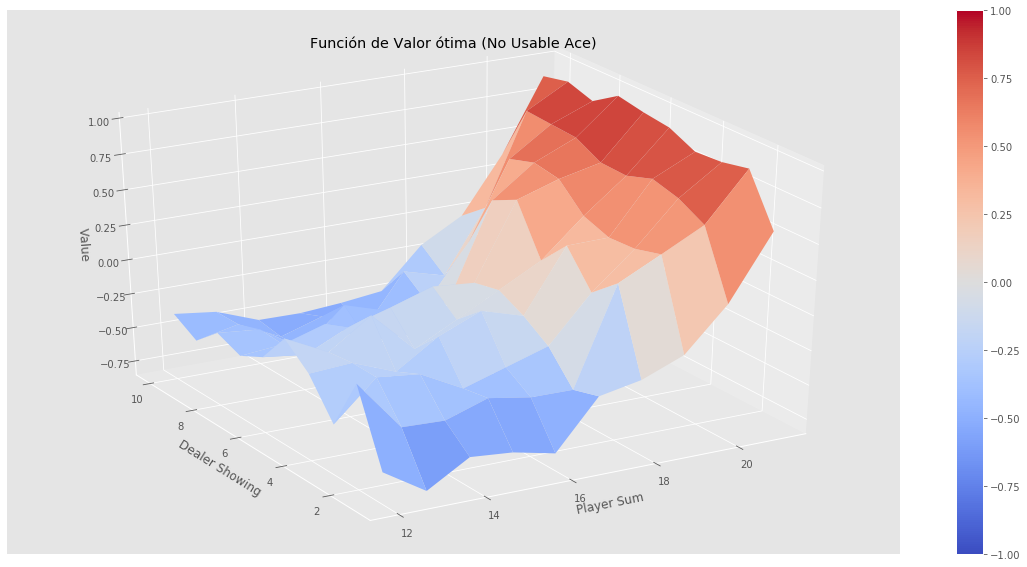

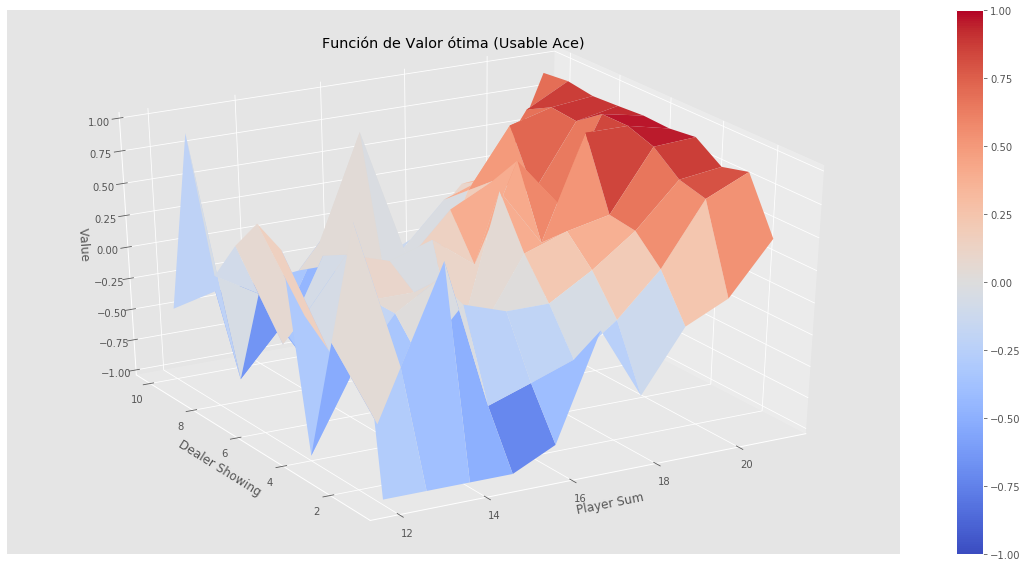

In [7]:
# Para plotear: crear una función valor dada una función valor de estado-acción
# eligiendo la mejor acción en cada estado
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Función de Valor ótima")

In [5]:
# ejemplo de cómo la política se actualiza cuando Q se actualiza
import numpy as np
from collections import defaultdict
tt = defaultdict(lambda: np.zeros(10))
def func_get_back_tt(tt):
    def tt_back(a):
        return tt[a]
    return tt_back
tt_back = func_get_back_tt(tt)
tt[0] += np.ones(10)
print(tt_back(0))
tt[0] += np.ones(10)
print(tt_back(0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
